<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

In [3]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def curva_roc(model, X_test, y_test):
    y_hat_prob = model.predict(X_test).ravel()

    # Calcular la exactitud (accuracy)
    scores = model.evaluate(X_test, y_test)
    print("Accuracy:", scores[1])

    fpr, tpr, thresholds = roc_curve(y_test, y_hat_prob)
    auc_keras = auc(fpr, tpr)
    print('auc_keras', auc_keras)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Curva ROC test')
    plt.legend(loc='best')
    plt.show()

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [4]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)

In [5]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')

### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [6]:
try:
    df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
    df.drop(columns = ['Unnamed: 0'], inplace = True)
    df_reviews['Rating'] = df_reviews['Rating'] - 1
    df_reviews.rename(columns = {'Review Text': 'reviews', 'Rating': 'rating'}, inplace = True)
except:
    pass

print('Total number of reviews: ', df_reviews.shape[0])
print(df_reviews.head())

Total number of reviews:  22641
                                             reviews  rating
0  Absolutely wonderful - silky and sexy and comf...       3
1  Love this dress!  it's sooo pretty.  i happene...       4
2  I had such high hopes for this dress and reall...       2
3  I love, love, love this jumpsuit. it's fun, fl...       4
4  This shirt is very flattering to all due to th...       4


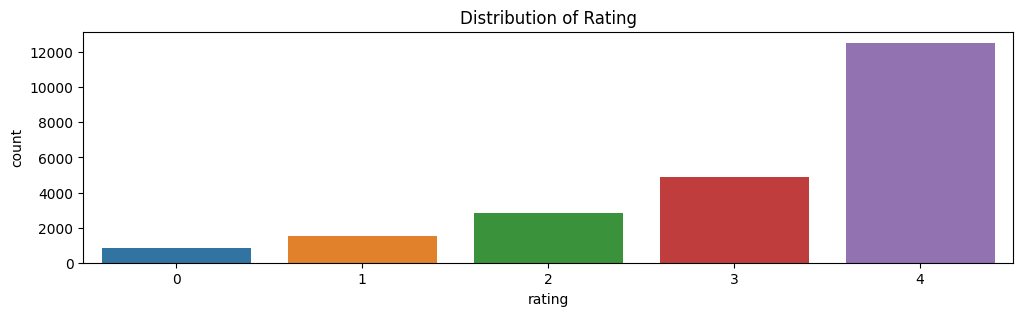

In [7]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase

# Plot the distribution of each class
plt.figure(figsize=(12,3))
sns.countplot(x='rating', data=df_reviews)
plt.title('Distribution of Rating')
plt.show()

In [8]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = df_reviews['reviews'].values

In [9]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
len(text_sequences)

22641

In [10]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(text_sequences)

In [11]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(corpus)

7011643

In [12]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [13]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [14]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens)

1372203

### Tokenizar las palabras

In [15]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(tokens)

In [16]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

14847

In [17]:
# Alumno: Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)
print(sequences[:1])
print(text_sequences[:1])

[[253, 532, 917, 3, 662, 3, 68]]
['Absolutely wonderful - silky and sexy and comfortable']


Max length: 115


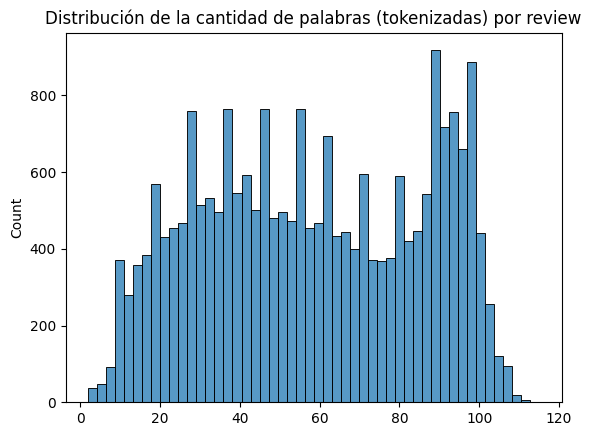

In [18]:
# Alumno: Determinar cual es la oración más larga
maxlen = max(len(s) for s in sequences)
print(f'Max length: {maxlen}')

# Podríamos optimizar el largo de la sentencia a analizar basandonos en la distribución
# de la cantidad de palabras por review. Sin embargo, por ahora vamos a tomar la máxima
len_vector = []
for i in sequences:
    len_vector.append(len(i))
sns.histplot(len_vector, bins=50)
plt.title('Distribución de la cantidad de palabras (tokenizadas) por review')
plt.show()

In [19]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.utils import pad_sequences

# Al realizar padding obtener la variable "X" (input)
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)
# Alumno: Observar las dimensiones de la variable input
X.shape


(22641, 115)

In [20]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)
y = df_reviews['rating'].values

# convert y into one-hot format
n_classes = df_reviews['rating'].unique().shape[0]
print(f'Cantidad de clases: {n_classes}')
y = to_categorical(y, num_classes=n_classes)
print(y)
print(y.shape)

Cantidad de clases: 5
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]
(22641, 5)


### Separacion test-train

In [21]:
def plot_class_percentage(ohe_array, text):
    data= pd.DataFrame(ohe_array)
    data = data.apply(pd.value_counts)
    data = data.iloc[1, :]
    # print(data)
    plt.title('Class Distribution: ' + text)
    palette_color = sns.color_palette('bright')
    plt.pie(data, labels=data.index, colors=palette_color, autopct='%.0f%%')

X_train: (18112, 115)


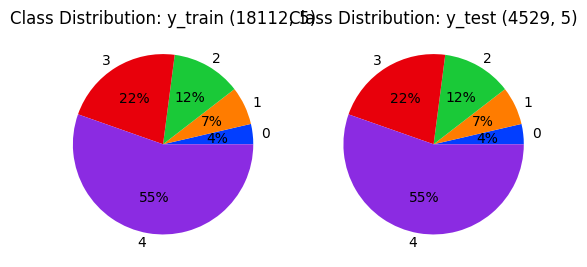

In [22]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"X_train: {X_train.shape}")
plt.subplot(1, 2, 1)
plot_class_percentage(y_train, f'y_train {y_train.shape}')
plt.subplot(1, 2, 2)
plot_class_percentage(y_test, f'y_test {y_test.shape}')
plt.show()
# Podemos ver que la proporción de clases se mantiene en train y test, pero es muy desbalanceada


#### Oversampling

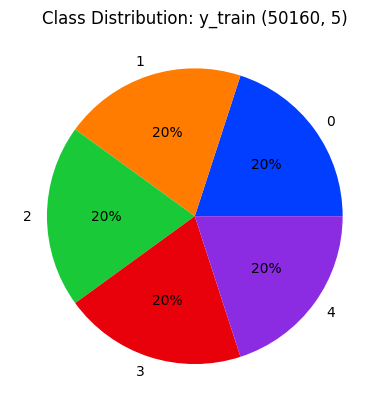

In [23]:
# Hacemos oversampling para tener una muestra balanceada
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
# oversampler = SMOTE(random_state=0, sampling_strategy=0.1)
oversampler = RandomOverSampler(sampling_strategy='all', shrinkage=0.5)
X_train, y_train = oversampler.fit_resample(X_train, y_train)
# undersampler=RandomUnderSampler(sampling_strategy='majority')
# X_train, y_train = undersampler.fit_resample(X_train, y_train)

plot_class_percentage(y_train, f'y_train {y_train.shape}')


### 2 - Entrenar el modelo con Embeddings + LSTM

In [24]:
# Alumno: determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
out_shape = n_classes # class classification
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 115 , out_shape 5


In [25]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = sentencias con padding a 200
# output_dim = 50 --> crear embeddings de tamaño 50
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='sigmoid'))

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 115, 50)           100050    
                                                                 
 lstm (LSTM)                 (None, 115, 64)           29440     
                                                                 
 dropout (Dropout)           (None, 115, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 6

In [26]:
X_train_t, X_val, y_train_t, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
hist = model.fit(X_train_t, y_train_t, validation_data=(X_val, y_val), epochs=50)

Epoch 1/50
1176/1176 [==============================] - 69s 51ms/step - loss: 1.2716 - accuracy: 0.3825 - val_loss: 1.2262 - val_accuracy: 0.4028
Epoch 2/50
1176/1176 [==============================] - 28s 24ms/step - loss: 1.2095 - accuracy: 0.4063 - val_loss: 1.2096 - val_accuracy: 0.3889
Epoch 3/50
1176/1176 [==============================] - 23s 20ms/step - loss: 1.1906 - accuracy: 0.4142 - val_loss: 1.2141 - val_accuracy: 0.4012
Epoch 4/50
1176/1176 [==============================] - 24s 21ms/step - loss: 1.1746 - accuracy: 0.4209 - val_loss: 1.2049 - val_accuracy: 0.4075
Epoch 5/50
1176/1176 [==============================] - 21s 18ms/step - loss: 1.1534 - accuracy: 0.4323 - val_loss: 1.2167 - val_accuracy: 0.4106
Epoch 6/50
1176/1176 [==============================] - 21s 18ms/step - loss: 1.1395 - accuracy: 0.4415 - val_loss: 1.2251 - val_accuracy: 0.4104
Epoch 7/50
1176/1176 [==============================] - 21s 18ms/step - loss: 1.1240 - accuracy: 0.4506 - val_loss: 1.2412 -

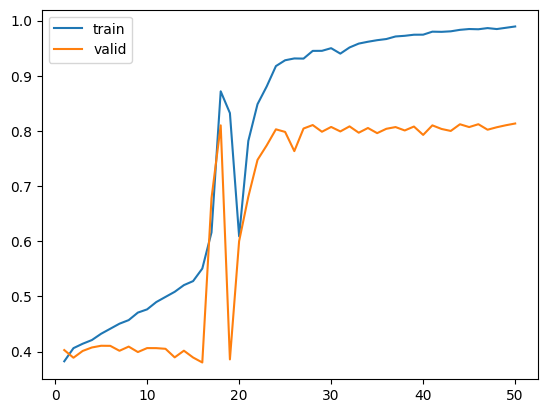

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [28]:
model.evaluate(X_test, y_test)

142/142 [==============================] - 2s 7ms/step - loss: 3.7084 - accuracy: 0.5739


[3.7083611488342285, 0.5738573670387268]